## LIBRAIRIES

In [50]:
import pandas as pd
import numpy  as np
from sklearn.model_selection import train_test_split
import pickle
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow import keras 
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Input
from tensorflow.keras.layers import Flatten, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import BatchNormalization,Dropout

## IMPORTING DATA

In [21]:
import os.path

fichierini = 'C:/Users/Bolbol/Desktop/csv/FINAL'           # file generated in the 'Data_Preprocessing_DL'

#OOpen the file if it exists and retrieve the list
if os.path.isfile(fichierini):
    fichierSauvegarde = open(fichierini,"rb")
    variables = pickle.load(fichierSauvegarde)
    fichierSauvegarde.close()

    #Affichage de la liste
   # print(variables)


In [22]:
X=variables[0]     # the values of each CSV file
Y=variables[1]     # the target of each file

In [23]:
print(X.shape)
print(Y.shape)

(2648, 10000, 23)
(2648,)


## SPLITTING THE DATA

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=0.1, 
                                                    random_state=0)


X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.1, 
                                                  random_state=0)

In [25]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(2144, 10000, 23)
(265, 10000, 23)
(2144,)
(265,)
(239, 10000, 23)
(239,)


## SCALING THE DATA

In [26]:
from sklearn.preprocessing import StandardScaler

scalers = {}
for i in range(X_train.shape[1]):
    scalers[i] = StandardScaler()
    X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 

for i in range(X_test.shape[1]):
    X_test[:, i, :] = scalers[i].transform(X_test[:, i, :]) 
    
for i in range(X_test.shape[1]):
    X_val[:, i, :] = scalers[i].transform(X_val[:, i, :]) 

# MODELING

## 1D CNN

In [45]:
import tensorflow as tf

In [51]:
# Returns a short sequential model
def create_model(input_shape, flatten=False):
  clear_session()
  model_cnn = Sequential()

  # this just tells the model what input shape to expect
  model_cnn.add(Input(shape=input_shape[1:]))
  for i in range(2):
    model_cnn.add(Conv1D(filters=64,
                    kernel_size=3,
                    padding="same",
                    activation='relu'))
    model_cnn.add(BatchNormalization())
    
    model_cnn.add(MaxPooling1D(pool_size=3, # size of the window
                       strides=2,   # factor to downsample
                       padding='same'))
    
    model_cnn.add(Dropout(0.25))
  for i in range(2):
    model_cnn.add(Conv1D(filters=128,
                    kernel_size=3,
                    padding="same",
                    activation='relu'))
    model_cnn.add(BatchNormalization())
    #model.add(Dropout(0.5))
  if flatten:
    model_cnn.add(Flatten())
  else:
    model_cnn.add(GlobalAveragePooling1D())
    model_cnn.add(Dropout(0.5))
  model_cnn.add(Dense(units=64,
                  activation='relu'))
  model_cnn.add(BatchNormalization())
  #model.add(Dropout(0.5))
  model_cnn.add(Dense(units=1,
                  activation='sigmoid'))

  model_cnn.compile(optimizer=Adam(0.001),
                loss='binary_crossentropy',
                metrics=['accuracy', 'AUC', 'Recall', 'Precision'])

  return model

clear_session()
# Create a basic model instance
model_cnn = create_model(X_train.shape)
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 10000, 64)         4480      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5000, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5000, 64)          12352     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2500, 64)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2500, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2500, 128)         49280     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0

In [52]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

def create_callbacks(best_model_filepath):

  callback_checkpoint = ModelCheckpoint(filepath=best_model_filepath,
                                        monitor='val_accuracy',
                                        verbose=0,
                                        save_weights_only=True,
                                        save_best_only=True)
  
  callback_early_stopping = EarlyStopping(monitor='val_accuracy',
                                          patience=10, 
                                          verbose=1)
  
  #callback_tensorboard = TensorBoard(log_dir=tensorboard_logs_filepath,
                                   #  histogram_freq=0,
                                     #write_graph=False)
  
  callback_reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                                         factor=0.1,
                                         min_lr=1e-4,
                                         patience=0,
                                         verbose=1)
  
  return [callback_checkpoint, callback_early_stopping,
          callback_reduce_lr]

In [54]:
from sklearn.utils import class_weight

EPOCHS = 50
BATCH_SIZE = 32
best_model_filepath = "C:/Users/Bolbol/Desktop/final_models/CNN_1D/CNN1D_Model.ckpt"

history_1D = model.fit(X_train, 
                       y_train,
                       batch_size=BATCH_SIZE, 
                       epochs=EPOCHS,
                       validation_data = (X_val, y_val),
                       callbacks=create_callbacks(best_model_filepath),
                       verbose=1)

Epoch 1/50
67/67 [==============================] - 34s 507ms/step - loss: 0.2817 - accuracy: 0.9007 - val_loss: 0.3082 - val_accuracy: 0.8870
Epoch 2/50
67/67 [==============================] - 35s 527ms/step - loss: 0.2780 - accuracy: 0.8988 - val_loss: 0.3112 - val_accuracy: 0.8787
Epoch 3/50
67/67 [==============================] - 36s 538ms/step - loss: 0.2782 - accuracy: 0.9002 - val_loss: 0.3093 - val_accuracy: 0.8828
Epoch 4/50
67/67 [==============================] - 38s 563ms/step - loss: 0.2771 - accuracy: 0.8974 - val_loss: 0.3082 - val_accuracy: 0.8870
Epoch 5/50
67/67 [==============================] - 39s 579ms/step - loss: 0.2752 - accuracy: 0.9011 - val_loss: 0.3011 - val_accuracy: 0.8828
Epoch 6/50
67/67 [==============================] - 35s 530ms/step - loss: 0.2724 - accuracy: 0.9002 - val_loss: 0.3042 - val_accuracy: 0.8828
Epoch 7/50
67/67 [==============================] - 36s 531ms/step - loss: 0.2702 - accuracy: 0.9016 - val_loss: 0.2976 - val_accuracy: 0.8870

## RNN 

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

model_rnn = Sequential()
model_rnn.add(LSTM(128, input_shape=(X_train.shape[1:]), activation='relu', return_sequences=True))
model_rnn.add(BatchNormalization())
model_rnn.add(Dropout(0.2))

model_rnn.add(LSTM(128, activation='relu'))
model_rnn.add(BatchNormalization())
model_rnn.add(Dropout(0.1))

model_rnn.add(Dense(32, activation='relu'))
model_rnn.add(BatchNormalization())
model_rnn.add(Dropout(0.2))

model_rnn.add(Dense(1, activation='relu'))

In [57]:
model_rnn = create_model(X_train.shape) 
model_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 10000, 64)         4480      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5000, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5000, 64)          12352     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2500, 64)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2500, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2500, 128)         49280     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0

In [58]:
best_model_filepath = "C:/Users/Bolbol/Desktop/final_models/RNN_1D/RNN1D_Model.ckpt"

opt=tf.keras.optimizers.Adam(0.001)
model_rnn.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy'],
)

history_rnn = model_rnn.fit(X_train,  y_train, 
                    batch_size=64, epochs=50,
                    callbacks=create_callbacks(best_model_filepath),
                    validation_data=(X_val, y_val))


Epoch 1/50
34/34 [==============================] - 34s 1s/step - loss: 0.3209 - accuracy: 0.8853 - val_loss: 0.3131 - val_accuracy: 0.8954
Epoch 2/50
34/34 [==============================] - ETA: 0s - loss: 0.2900 - accuracy: 0.8960
Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
34/34 [==============================] - 35s 1s/step - loss: 0.2900 - accuracy: 0.8960 - val_loss: 0.3275 - val_accuracy: 0.8619
Epoch 3/50
34/34 [==============================] - ETA: 0s - loss: 0.2694 - accuracy: 0.8983
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0001.
34/34 [==============================] - 35s 1s/step - loss: 0.2694 - accuracy: 0.8983 - val_loss: 0.3036 - val_accuracy: 0.8745
Epoch 4/50
34/34 [==============================] - 35s 1s/step - loss: 0.2643 - accuracy: 0.9058 - val_loss: 0.3051 - val_accuracy: 0.8745
Epoch 5/50
34/34 [==============================] - 35s 1s/step - loss: 0.2641 - accuracy: 0.9030 - val_loss: 0.3035 - val_accur

## VGGNet

In [60]:
from functools import partial
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization, Input, Reshape, Flatten, Reshape,  add
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam

def VGGNet_conv_layer(model, filter_num, kernel_size, layer_no, DefaultConv, 
                      DefaultMaxPooling):
  if layer_no <= 2:
    conv_layers = 2
  else:
    conv_layers = 4

  for i in range(conv_layers):
    model.add(DefaultConv(filters=filter_num,
                          kernel_size=kernel_size))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
  model.add(DefaultMaxPooling())

  return model

def create_VGGNet_model(input_shape, target_shape, dim='1D', first_filters=64, 
                        kernel=3, conv_layers=5, first_units = 100, dense_layers = 2, 
                        flatten=False):
  clear_session()
  model = Sequential()

  # ------------
  # Input Layers
  # ------------
  model.add(Input(shape=input_shape))
  model.add(Reshape(target_shape))

  # -----------
  # Conv Layers
  # -----------
  if dim == '1D':
    DefaultConv = partial(Conv1D,
                          padding="SAME")
    DefaultMaxPooling = partial(MaxPooling1D,
                                pool_size=2)
    DefaultGlobalAveragePooling = partial(GlobalAveragePooling1D)
  

  for layer_no in range(conv_layers):
    # means it starts at 1 rather than 0
    layer_no+=1

    if not layer_no == 5:
      filter_num = first_filters*layer_no
    else:
      filter_num = first_filters*4

    model = VGGNet_conv_layer(model, filter_num, kernel, layer_no, DefaultConv, 
                              DefaultMaxPooling)

  # ------------
  # Dense Layers
  # ------------
  if flatten:
    model.add(Flatten())
  else:
    model.add(DefaultGlobalAveragePooling())

  for layer_no in range(dense_layers):
    layer_no+=1
    model.add(Dense(units=int(first_units/layer_no)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(rate=0.5))

  # ------------
  # Output Layer
  # ------------
  model.add(Dense(units=1, activation='sigmoid'))
    
  model.compile(optimizer=Adam(0.001),
                loss='binary_crossentropy',
                metrics=['accuracy', 'AUC', 'Recall', 'Precision'])
  
  return model

In [61]:
def data_shapes(data):
  target_shape = data.shape[1:]
  data_reshape = np.reshape(data, (data.shape[0], -1))
  input_shape = data_reshape.shape[1:]
  
  return input_shape, target_shape, data_reshape

reshape_input_filt, reshape_target_filt, X_train_filt_reshape = data_shapes(X_train)
reshape_input_filt, reshape_target_filt, X_val_filt_reshape = data_shapes(X_val)

display(reshape_target_filt)
display(reshape_input_filt)
display(X_train_filt_reshape.shape)

(10000, 23)

(230000,)

(2144, 230000)

In [62]:
VGGNet1D_model = create_VGGNet_model(reshape_input_filt, reshape_target_filt, dim='1D')
VGGNet1D_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 10000, 23)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 10000, 64)         4480      
_________________________________________________________________
batch_normalization (BatchNo (None, 10000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 10000, 64)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10000, 64)         12352     
_________________________________________________________________
batch_normalization_1 (Batch (None, 10000, 64)         256       
_________________________________________________________________
activation_1 (Activation)    (None, 10000, 64)         0

In [63]:
from imblearn.keras import balanced_batch_generator

# reduce the batch size as there is less training data than before
BATCH_SIZE = 32
EPOCHS=30
best_model_filepath = "C:/Users/Bolbol/Desktop/final_models/VGGNet_1D/VGGNet1D_Model.ckpt"


generator_1D, steps_per_epoch_1D = balanced_batch_generator(X_train_filt_reshape, 
                                                            y_train, 
                                                            batch_size=BATCH_SIZE)
# Train
history_VGGNet1D = VGGNet1D_model.fit_generator(generator=generator_1D,
                                                epochs=EPOCHS,
                                                steps_per_epoch=steps_per_epoch_1D,
                                                validation_data = (X_val_filt_reshape, 
                                                                   y_val),
                                                callbacks=create_callbacks(best_model_filepath) ,
                                                                        verbose=1)



Epoch 1/30
64/64 [==============================] - 401s 6s/step - loss: 0.5634 - accuracy: 0.7793 - auc: 0.8134 - recall: 0.7135 - precision: 0.8225 - val_loss: 0.6525 - val_accuracy: 0.6109 - val_auc: 0.8317 - val_recall: 0.3120 - val_precision: 0.8478
Epoch 2/30
64/64 [==============================] - 411s 6s/step - loss: 0.4545 - accuracy: 0.8361 - auc: 0.8675 - recall: 0.7852 - precision: 0.8749 - val_loss: 0.5194 - val_accuracy: 0.7782 - val_auc: 0.8675 - val_recall: 0.6560 - val_precision: 0.8913
Epoch 3/30
64/64 [==============================] - ETA: 0s - loss: 0.4260 - accuracy: 0.8465 - auc: 0.8833 - recall: 0.7972 - precision: 0.8838
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
64/64 [==============================] - 416s 6s/step - loss: 0.4260 - accuracy: 0.8465 - auc: 0.8833 - recall: 0.7972 - precision: 0.8838 - val_loss: 0.5925 - val_accuracy: 0.7322 - val_auc: 0.8829 - val_recall: 0.5360 - val_precision: 0.9178
Epoch 4/30
64/64 [==

In [ ]:
plot_progress(history_VGGNet1D.history)

## ResNet

In [65]:
from tensorflow.keras import activations, models, layers

class ResidualUnit(layers.Layer):
    def __init__(self, filters, kernel, DefaultConv, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = activations.get(activation)
        self.main_layers = [
            DefaultConv(filters, kernel, strides=strides),
            BatchNormalization(),
            self.activation,
            DefaultConv(filters, kernel),
            BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv(filters, kernel_size=1, strides=strides),
                BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)


def get_layers(layers, int_filter):
  filters = []
  
  if layers == 1:
    pass
  elif layers == 2:
    filters = [int_filter]
  elif layers == 3:
    filters = [int_filter, int_filter*2]
  elif layers == 4:
    filters = [int_filter, int_filter*2, int_filter*4]
  elif layers == 5:
    filters = [int_filter, int_filter*2] + [int_filter*4]*2
  elif layers == 6:
    filters = [int_filter] + [int_filter*2]*2 + [int_filter*4]*2
  elif layers == 7:
    filters = [int_filter] + [int_filter*2]*2 + [int_filter*4]*3
  elif layers == 8:
    filters = [int_filter] + [int_filter*2]*3 + [int_filter*4]*3
  elif layers == 9:
    filters = [int_filter]*2 + [int_filter*2]*3 + [int_filter*4]*3
  elif layers == 10:
    filters = [int_filter]*2 + [int_filter*2]*3 + [int_filter*4]*4

  return filters

def create_ResNet_model(input_shape, target_shape, dim='1D', first_filters=64, 
                        kernel=6, conv_layers=10, first_units = 100, dense_layers = 2, 
                        flatten=False):
  clear_session()

  # ------------
  # Input Layers
  # ------------
  inputs = Input(shape=input_shape)
  re = Reshape(target_shape)(inputs)

  # -----------
  # Conv Layers
  # -----------
  if dim == '1D':
    DefaultConv = partial(Conv1D,
                          padding="SAME",
                          use_bias=False)
    DefaultMaxPooling = partial(MaxPooling1D,
                                pool_size=2,
                                padding="SAME")
    DefaultGlobalAveragePooling = partial(GlobalAveragePooling1D)
  

  
  prev_filters = first_filters
  x = DefaultConv(filters=first_filters, kernel_size=kernel, strides=2)(re)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = DefaultMaxPooling(pool_size=2, padding="SAME")(x)
  
  filters_list = get_layers(conv_layers, first_filters*2)
  for filter_num in filters_list:
    strides = 1 if filter_num == prev_filters else 2
    x = ResidualUnit(filter_num, int(kernel/2), DefaultConv, strides=strides)(x)
    prev_filters = filter_num

  # ------------
  # Dense Layers
  # ------------
  if flatten:
    x = Flatten()(x)
  else:
    x = DefaultGlobalAveragePooling()(x)

  for layer_no in range(dense_layers):
    layer_no+=1
    x = Dense(units=int(first_units/layer_no))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(rate=0.5)(x)

  # ------------
  # Output Layer
  # ------------
  output = Dense(units=1, activation='sigmoid')(x)

  model_resnet = models.Model(inputs=[inputs], outputs=[output])
    
  model_resnet.compile(optimizer=Adam(0.001),
                loss='binary_crossentropy',
                metrics=['accuracy', 'AUC', 'Recall', 'Precision'])
  
  return model_resnet

In [66]:
ResNet1D_model = create_ResNet_model(reshape_input_filt, reshape_target_filt, dim='1D')
ResNet1D_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 230000)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 10000, 23)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 5000, 64)          8832      
_________________________________________________________________
batch_normalization (BatchNo (None, 5000, 64)          256       
_________________________________________________________________
activation (Activation)      (None, 5000, 64)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2500, 64)          0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 1250, 128)        

In [67]:
best_model_filepath = "C:/Users/Bolbol/Desktop/final_models/ResNet_1D/ResNet1D_Model.ckpt"


# Train
history_ResNet1D = ResNet1D_model.fit_generator(generator=generator_1D,
                                                epochs=EPOCHS,
                                                steps_per_epoch=steps_per_epoch_1D,
                                                validation_data = (X_val, 
                                                                   y_val),
                                                callbacks=create_callbacks(best_model_filepath), 
                                                                        verbose=1)

Epoch 1/30
64/64 [==============================] - 272s 4s/step - loss: 0.5160 - accuracy: 0.7858 - auc: 0.8374 - recall: 0.7754 - precision: 0.7925 - val_loss: 0.6387 - val_accuracy: 0.8075 - val_auc: 0.8378 - val_recall: 0.6800 - val_precision: 0.9341
Epoch 2/30
64/64 [==============================] - 266s 4s/step - loss: 0.4557 - accuracy: 0.8366 - auc: 0.8712 - recall: 0.7803 - precision: 0.8800 - val_loss: 0.7163 - val_accuracy: 0.8368 - val_auc: 0.8958 - val_recall: 0.7600 - val_precision: 0.9135
Epoch 3/30
64/64 [==============================] - ETA: 0s - loss: 0.4407 - accuracy: 0.8416 - auc: 0.8831 - recall: 0.7950 - precision: 0.8757
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
64/64 [==============================] - 265s 4s/step - loss: 0.4407 - accuracy: 0.8416 - auc: 0.8831 - recall: 0.7950 - precision: 0.8757 - val_loss: 0.6711 - val_accuracy: 0.8326 - val_auc: 0.8956 - val_recall: 0.7520 - val_precision: 0.9126
Epoch 4/30
64/64 [==

### Plotting accuracy and Loss curves

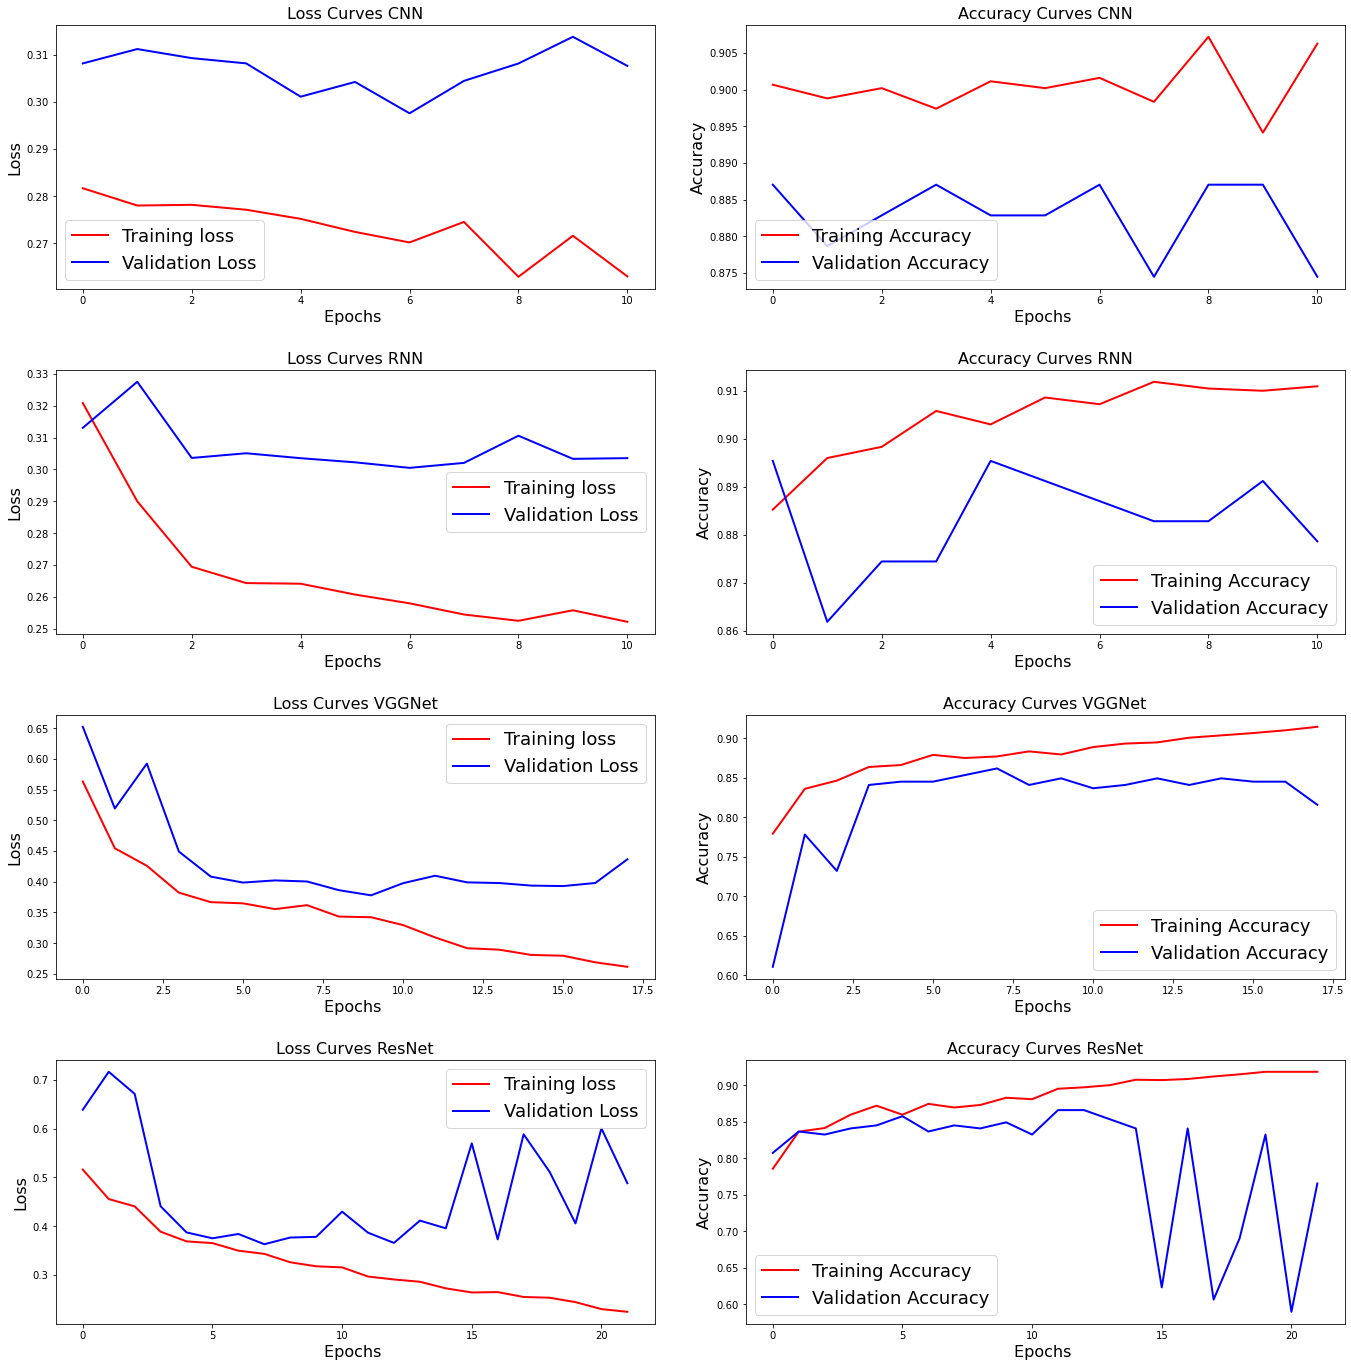

In [140]:

fig,axes=plt.subplots(4,2,figsize=(20, 20))
fig.tight_layout(pad=6)
for (m,history), ax in zip({'CNN':history_1D,'RNN':history_rnn,'VGGNet':history_VGGNet1D,'ResNet':history_ResNet1D}.items(),axes):
    # Loss Curves
    
    ax[0].plot(history.history['loss'],'r',linewidth=2.0)
    ax[0].plot(history.history['val_loss'],'b',linewidth=2.0)
    ax[0].legend(['Training loss', 'Validation Loss'],fontsize=18)
    ax[0].set_xlabel('Epochs ',fontsize=16)
    ax[0].set_ylabel('Loss',fontsize=16)
    ax[0].set_title('Loss Curves '+m,fontsize=16)
 
    # Accuracy Curves
    ax[1].plot(history.history['accuracy'],'r',linewidth=2.0)
    ax[1].plot(history.history['val_accuracy'],'b',linewidth=2.0)
    ax[1].legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    ax[1].set_xlabel('Epochs ',fontsize=16)
    ax[1].set_ylabel('Accuracy',fontsize=16)
    ax[1].set_title('Accuracy Curves '+m,fontsize=16)

### Classification reports

In [ ]:
from sklearn.metrics import classification_report
l=['CNN1D','RNN1D','VGGNet','Resnet']  
for model, i in zip ( [model,model_rnn,VGGNet1D_model,ResNet1D_model],[0,1,2,3]):
    y_pred=model.predict(X_test)
    y_pred = y_pred > 0.5
    y_pred=y_pred.astype(int)
    y_pred=y_pred.reshape(y_test.shape)
    print('\n                 Classification report '+ l[i] + '\n')
    print(classification_report(y_test, y_pred,digits=3))


                 Classification report CNN1D

              precision    recall  f1-score   support

           0      0.886     0.855     0.870       145
           1      0.832     0.867     0.849       120

    accuracy                          0.860       265
   macro avg      0.859     0.861     0.860       265
weighted avg      0.861     0.860     0.861       265


                 Classification report RNN1D

              precision    recall  f1-score   support

           0      0.904     0.910     0.907       145
           1      0.891     0.883     0.887       120

    accuracy                          0.898       265
   macro avg      0.897     0.897     0.897       265
weighted avg      0.898     0.898     0.898       265



###  Confusion Matrix

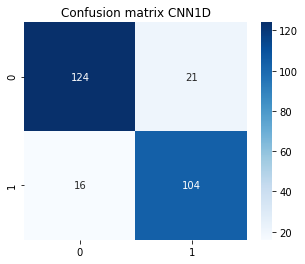

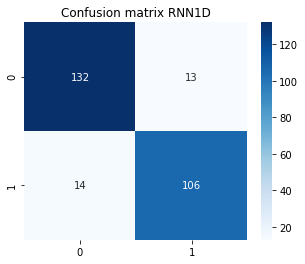

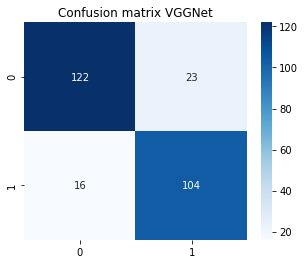

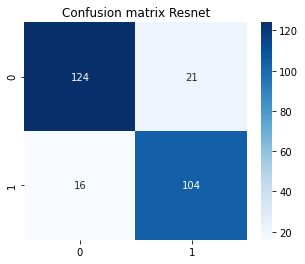

In [170]:
import seaborn as sn

#for model,i in zip([model_cnn,model_rnn,VGGNet1D_model,ResNet1D_model],[1,2,3,4]):
l=['CNN1D','RNN1D','VGGNet','Resnet']    
for model,i in zip ([model,model_rnn,VGGNet1D_model,ResNet1D_model],[1,2,3,4]):
    fig = figure(figsize=(5, 4))
    y_pred=model.predict(X_test)
    y_pred = y_pred > 0.5
    y_pred=y_pred.astype(int)
    y_pred=y_pred.reshape(y_test.shape)
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm, range(2), range(2))
    plt.title('Confusion matrix '+l[i-1])
    sn.heatmap(df_cm, annot=True,fmt='g',cmap ='Blues')# font size
    